<a href="https://colab.research.google.com/github/UrukHan/SuperResolution/blob/main/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.data.experimental import AUTOTUNE


In [ ]:
%cd /content/
!git clone https://github.com/krasserm/super-resolution

/content
Cloning into 'super-resolution'...
remote: Enumerating objects: 405, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 405 (delta 9), reused 19 (delta 8), pack-reused 385
Receiving objects: 100% (405/405), 54.27 MiB | 35.53 MiB/s, done.
Resolving deltas: 100% (209/209), done.


In [ ]:
%cd /content/super-resolution

from model.srgan import generator
from model import resolve_single
from train import SrganGeneratorTrainer
from utils import load_image, plot_sample

/content/super-resolution


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [ ]:
temp_path = '/content/gdrive/MyDrive/NeuroNet/TrainData.zip'
!cp $temp_path .
!unzip TrainData.zip -d /content &> /dev/null

In [ ]:
# !rm -rf '/content/dataset'

In [ ]:
path = glob.glob(r'/content/TrainData/*.jpg')
len(path), path[:3]

(19245,
 ['/content/TrainData/0002907.jpg',
  '/content/TrainData/JA222O1W3-Q11@8.jpg',
  '/content/TrainData/GA322O01A-Q11@14.1.jpg'])

In [ ]:
path_train, path_valid = train_test_split(path, test_size = 0.1, random_state = 42)
len(path_train), path_train[:3]

(17320,
 ['/content/TrainData/SU222O0M5-A11@17.jpg',
  '/content/TrainData/JA222S13H-K11@17.jpg',
  '/content/TrainData/TR122S01S-Q11@8.jpg'])

In [ ]:
!mkdir '/content/dataset'
!mkdir '/content/dataset/train_x'
!mkdir '/content/dataset/valid_x'
!mkdir '/content/dataset/train_y'
!mkdir '/content/dataset/valid_y'

In [ ]:
for i in tqdm(path_train):
  !cp $i '/content/dataset/train_y'
for i in tqdm(path_valid):
  !cp $i '/content/dataset/valid_y'

100%|██████████| 1925/1925 [03:42<00:00,  8.67it/s]


In [ ]:
x = 0
for i in path_train:
  x += 1
  temp = cv2.imread(i)
  temp = cv2.resize(temp, (int(temp.shape[1]/4), int(temp.shape[0]/4))) 
  cv2.imwrite(os.path.join('/content/dataset/train_x', i.split('/')[-1]), temp, [int(cv2.IMWRITE_JPEG_QUALITY), 30])
  if x % 1000 == 0:
    print(x, '  -  ', end = '')
x = 0
for i in path_valid:
  x += 1
  temp = cv2.imread(i)
  temp = cv2.resize(temp, (int(temp.shape[1]/4), int(temp.shape[0]/4))) 
  cv2.imwrite(os.path.join('/content/dataset/valid_x', i.split('/')[-1]), temp, [int(cv2.IMWRITE_JPEG_QUALITY), 30])
  if x % 1000 == 0:
    print(x, '  -  ', end = '')

1000   -  2000   -  3000   -  4000   -  5000   -  6000   -  7000   -  8000   -  9000   -  10000   -  11000   -  12000   -  13000   -  14000   -  15000   -  16000   -  17000   -  1000   -  

In [ ]:
!zip -r /content/gdrive/MyDrive/NeuroNet/PF-AFN/train_x.zip /content/dataset/train_x   &> /dev/null
!zip -r /content/gdrive/MyDrive/NeuroNet/PF-AFN/valid_x.zip /content/dataset/valid_x   &> /dev/null
!zip -r /content/gdrive/MyDrive/NeuroNet/PF-AFN/train_y.zip /content/dataset/train_y   &> /dev/null
!zip -r /content/gdrive/MyDrive/NeuroNet/PF-AFN/valid_y.zip /content/dataset/valid_y   &> /dev/null

In [ ]:
!rm -rf '/content/data'

In [ ]:
!mkdir '/content/dataset'
!mkdir '/content/dataset/caches'
!mkdir '/content/dataset/images'
!mkdir '/content/dataset/images/train_x'
!mkdir '/content/dataset/images/valid_x'
!mkdir '/content/dataset/images/train_y'
!mkdir '/content/dataset/images/valid_y'

In [ ]:
temp_path = '/content/gdrive/MyDrive/NeuroNet/SuperRes/train_y.zip'
!cp $temp_path .
!unzip train_y.zip -d /content/dataset/images/train_y/ &> /dev/null

In [ ]:
temp_path = '/content/gdrive/MyDrive/NeuroNet/SuperRes/train_x.zip'
!cp $temp_path .
!unzip train_x.zip -d /content/dataset/images/train_x/ &> /dev/null

In [ ]:
temp_path = '/content/gdrive/MyDrive/NeuroNet/SuperRes/valid_y.zip'
!cp $temp_path .
!unzip valid_y.zip -d /content/dataset/images/valid_y/ &> /dev/null

In [ ]:
temp_path = '/content/gdrive/MyDrive/NeuroNet/SuperRes/valid_x.zip'
!cp $temp_path .
!unzip valid_x.zip -d /content/dataset/images/valid_x/ &> /dev/null

In [ ]:
hr_image_files_train = glob.glob(r'/content/dataset/images/train_y/*.jpg')
lr_image_files_train = glob.glob(r'/content/dataset/images/train_x/*.jpg')
hr_image_files_valid = glob.glob(r'/content/dataset/images/valid_y/*.jpg')
lr_image_files_valid = glob.glob(r'/content/dataset/images/valid_x/*.jpg')

In [ ]:
scale = 4

def images_dataset(image_files):
    ds = tf.data.Dataset.from_tensor_slices(image_files)
    ds = ds.map(tf.io.read_file)
    ds = ds.map(lambda x: tf.image.decode_jpeg(x, channels=3), num_parallel_calls = AUTOTUNE)
    return ds

def train_dataset(batch_size = 16):
    ds = tf.data.Dataset.zip((
        images_dataset(lr_image_files_train[:10000]).cache('/content/dataset/caches/train_x.cache'),
        images_dataset(hr_image_files_train[:10000]).cache('/content/dataset/caches/train_y.cache')))
    
    ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale = scale), num_parallel_calls = AUTOTUNE)
    ds = ds.map(random_rotate, num_parallel_calls = AUTOTUNE)
    ds = ds.map(random_flip, num_parallel_calls = AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.repeat(None)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

def valid_dataset(batch_size = 16):
    ds = tf.data.Dataset.zip((
        images_dataset(lr_image_files_valid[:500]).cache('/content/dataset/caches/valid_x.cache'),
        images_dataset(hr_image_files_valid[:500]).cache('/content/dataset/caches/valid_y.cache')))
    
    ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale = scale), num_parallel_calls = AUTOTUNE)
    ds = ds.map(random_rotate, num_parallel_calls = AUTOTUNE)
    ds = ds.map(random_flip, num_parallel_calls = AUTOTUNE)

    ds = ds.batch(batch_size)
    ds = ds.repeat(None)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def random_crop(lr_img, hr_img, hr_crop_size = 96, scale = 2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)

In [ ]:
train_ds = train_dataset(batch_size = 16) 
valid_ds = valid_dataset(batch_size = 16)

In [ ]:
pre_trainer = SrganGeneratorTrainer(model = generator(), checkpoint_dir = f'.ckpt/pre_generator')

pre_trainer.model.load_weights('/content/gdrive/MyDrive/NeuroNet/SuperRes/reserve/pre_generator.h5')

pre_trainer.train(train_ds, valid_ds.take(10), steps = 20000, evaluate_every = 1000)

pre_trainer.model.save_weights('/content/gdrive/MyDrive/NeuroNet/SuperRes/pre_generator.h5')

In [ ]:
#1000/1000: loss = 575.467, PSNR = 26.986975 (7372.36s)
#1000/2000: loss = 331.271, PSNR = 28.320160 (6949.08s)
#2000/2000: loss = 301.204, PSNR = 27.782059 (6998.83s)
#2000/3000: loss = 292.597, PSNR = 29.767319 (8587.86s)
#10000/10000: loss = 256.496, PSNR = 23.508081 (923.15s)
#10000/10000: loss = 254.478, PSNR = 28.900730 (928.45s)

In [ ]:
model = generator()
model.load_weights('/content/gdrive/MyDrive/NeuroNet/SuperRes/reserve/pre_generator.h5')

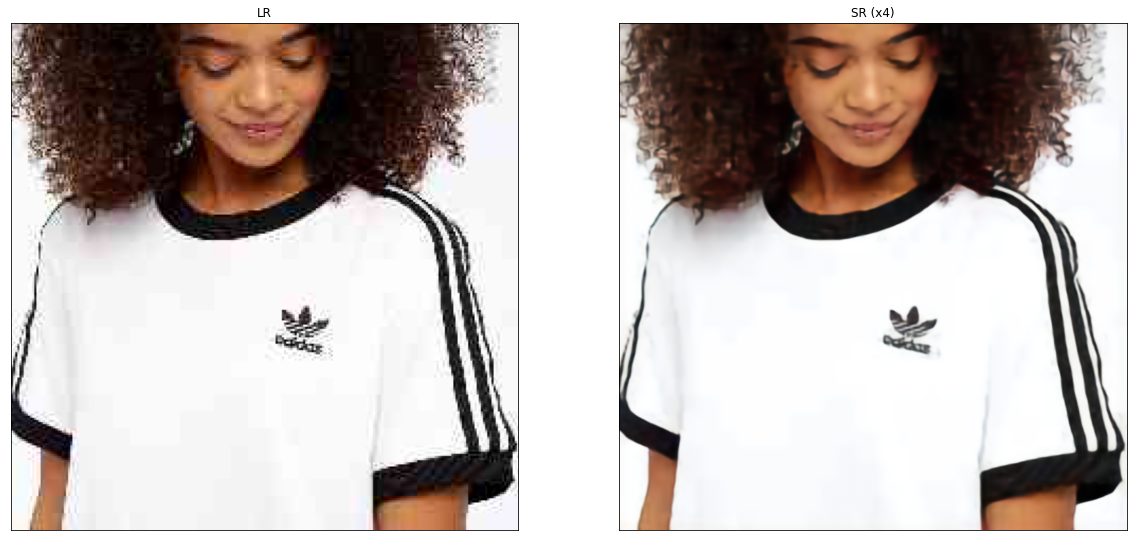

In [ ]:
lr = load_image('/content/dataset/images/train_x/0001116.jpg')
sr = resolve_single(model, lr)

plot_sample(lr, sr)